<a href="https://colab.research.google.com/github/seawavve/AmusementCycle/blob/main/preprocessing/watershed_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resize

In [ ]:
import imutils # 파이썬 OpenCV가 제공하는 기능 중 복잡하고 사용성이 떨어지는 부분을 보완(이미지 또는 비디오 스트림 파일 처리 등)
import cv2 # opencv 모듈

# 비디오 파일
video = "./gyro_swing_1.mp4" # "" 일 경우 webcam 사용

# 저장할 비디오 파일 경로 및 이름
result_path = "./result_video.avi"

# 비디오 경로가 제공되지 않은 경우 webcam 사용
if video == "":
    print("[webcam 시작]")
    vs = cv2.VideoCapture(0)

# 비디오 경로가 제공된 경우 video 사용
else:
    print("[video 시작]")
    vs = cv2.VideoCapture(video)

# 비디오 저장 변수
writer = None

# 비디오 스트림 프레임 반복
while True:
    # 프레임 읽기
    ret, frame = vs.read()

    # 읽은 프레임이 없는 경우 종료
    if frame is None:
        break

    # 프레임 resize
    frame = imutils.resize(frame, width=500)

    # 프레임 출력
    #cv2.imshow("frame", frame)
    
    # 'q' 키를 입력하면 종료
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
                                     
    # 저장할 비디오 설정
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(result_path, fourcc, 25, (frame.shape[1], frame.shape[0]), True)

    # 비디오 저장
    if writer is not None:
        writer.write(frame)

# 종료
vs.release()
cv2.destroyAllWindows()

[video 시작]


# Watershed

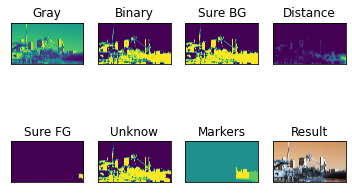

In [2]:
#TEST
#-*-coding:utf-8-*-

import cv2
import numpy as np
from matplotlib import pyplot as plt


# img = cv2.imread('images/watershed.jpg')
img = cv2.imread('water_example_fig.png')

# binaray image로 변환
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknow영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, img]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

plt.imshow(images[0])
for i in range(len(images)):
  plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()


In [ ]:
##### good: Gray, Binary, Sure BG, Result
##### best: Gray,SUre BG